# Prac 04

For this homework you are going to implement a lane line detector. Lane line detection is crucial for ADAS (Advanced Driver Assistance Systems) systems and, in particular, for LKA (Lane Keep Assist). You will use a [picture](https://en.wikipedia.org/wiki/Lane_departure_warning_system) from a front facing camera (mounted on the car) and will implement the following steps:
* Convert image to gray scale
* Compute edge map
* Apply Hough transform to obtain line parametrizations

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load and show the camera frame.

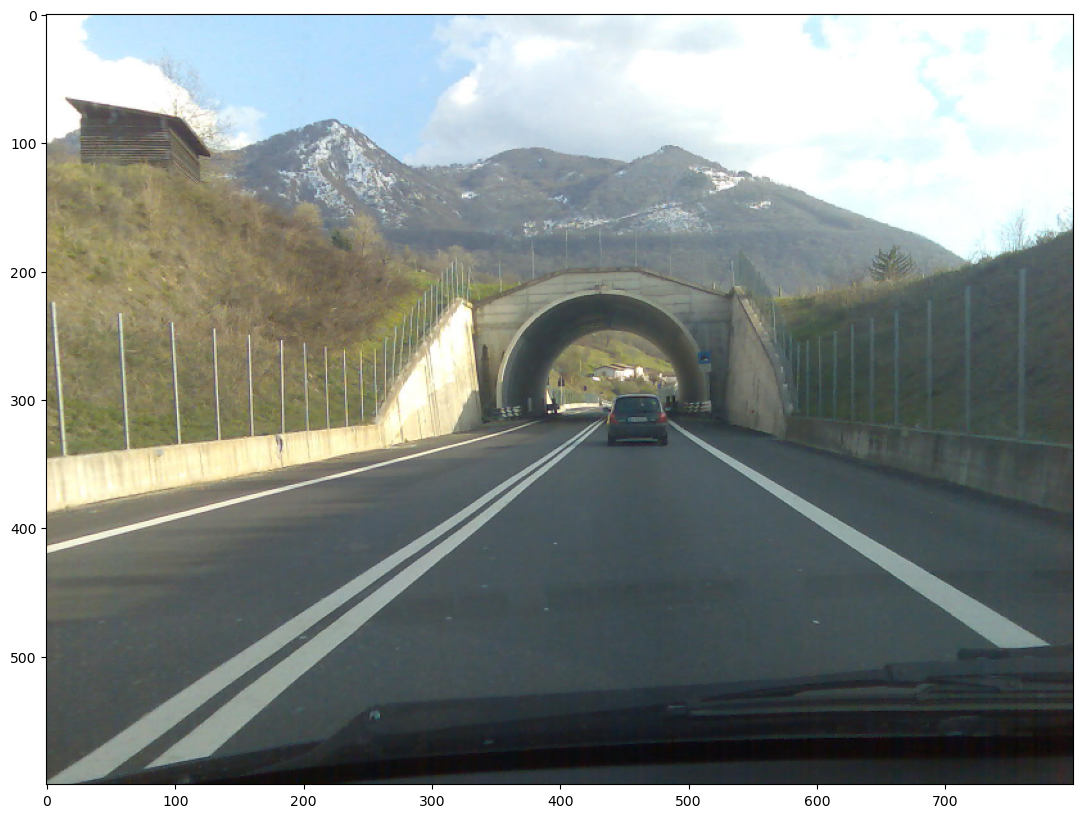

In [2]:
img = cv2.imread('data/dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)

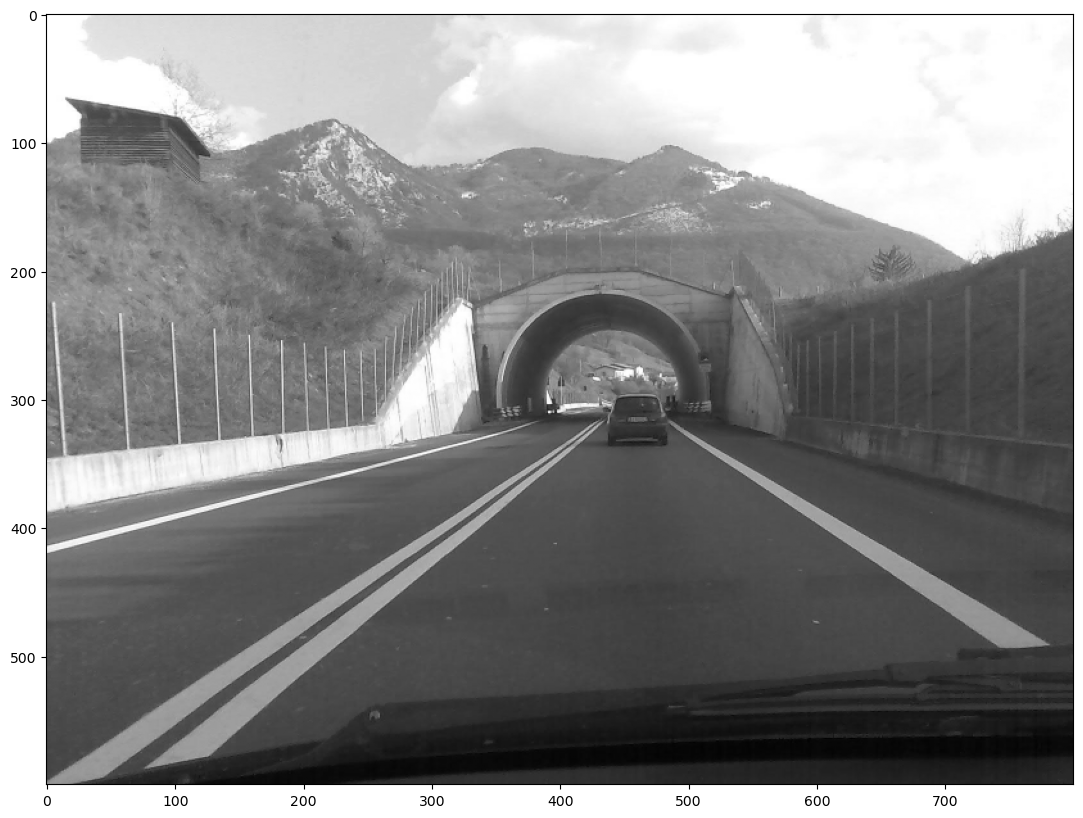

In [3]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

In [4]:
# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
edges = cv2.Canny(img, 100, 150)
# We are only interseted in the road so we will remove everything above the horizon
edges[0:350] = 0

(<Axes: title={'center': 'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

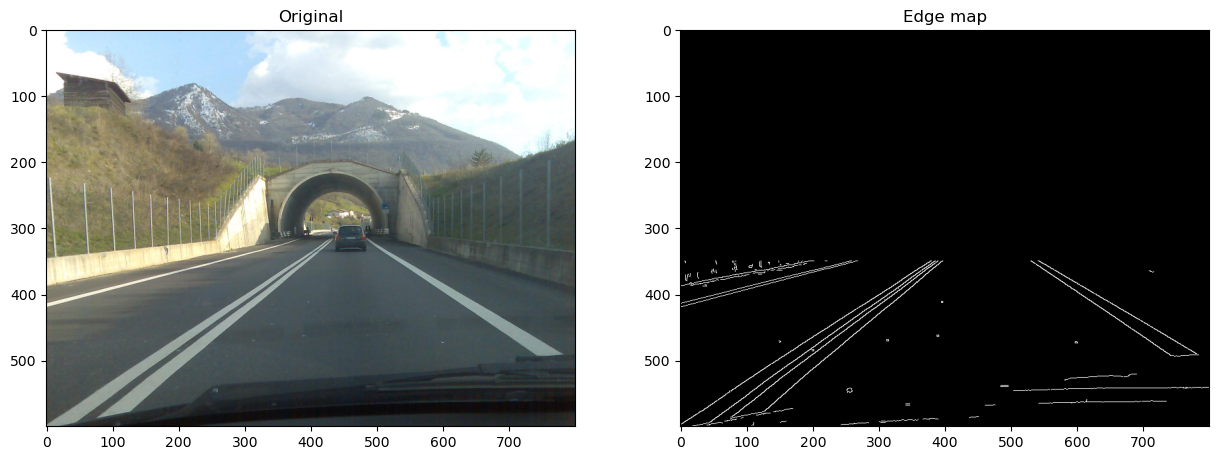

In [5]:
# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

In [15]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190
lines = cv2.HoughLines(edges, rho=2, theta=np.deg2rad(2), threshold=190) 
# Let's get rid of the unnecessary dimension
lines = lines[:, 0, :]
print(lines)

[[521.           0.87266463]
 [509.           0.9075712 ]
 [505.           0.94247776]
 [495.           0.9773844 ]
 [513.           0.94247776]
 [401.           1.3264502 ]
 [ -7.           2.1642082 ]
 [499.           1.012291  ]
 [ 31.           2.0943952 ]
 [541.           1.5707964 ]
 [511.           0.9773844 ]]


(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

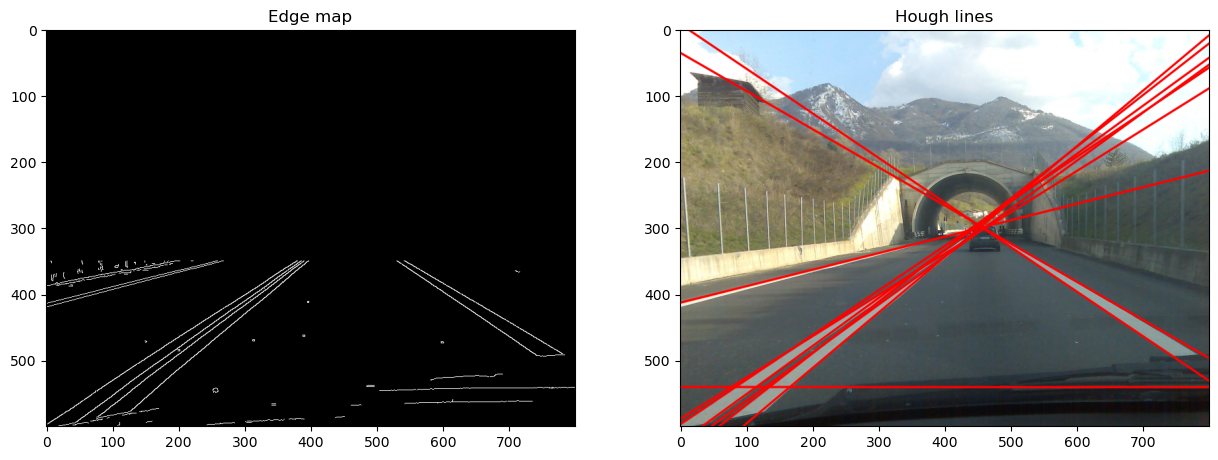

In [14]:
# Plot the resulting Hough lines
result = np.copy(img)
        
for line in lines:
    rho, theta = line
    
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
    pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
    
    cv2.line(result, pt1, pt2, (255,0,0), 2, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The edge map looks good but the Hough lines are too noisy. Let's clean the Hough lines first by removing all lines that we know cannot represent a lane line. In other words, all lines that are approximately horizontal shall be removed. Remember that horizontal lines correspond to theta = 90 degrees.

In [31]:
# Filter out all lines that are approximately horizontal (+/- 20 degrees). 
filtered_lines = []
for line in lines:
    rho, theta = line
    if not (np.pi/2 - np.deg2rad(20) < theta < np.pi/2 + np.deg2rad(20)):
        filtered_lines.append(line)

filtered_lines = np.array(filtered_lines)
print(f"{lines}\n --- \n{filtered_lines}")



[[521.           0.87266463]
 [509.           0.9075712 ]
 [505.           0.94247776]
 [495.           0.9773844 ]
 [513.           0.94247776]
 [401.           1.3264502 ]
 [ -7.           2.1642082 ]
 [499.           1.012291  ]
 [ 31.           2.0943952 ]
 [541.           1.5707964 ]
 [511.           0.9773844 ]]
 --- 
[[521.           0.87266463]
 [509.           0.9075712 ]
 [505.           0.94247776]
 [495.           0.9773844 ]
 [513.           0.94247776]
 [ -7.           2.1642082 ]
 [499.           1.012291  ]
 [ 31.           2.0943952 ]
 [511.           0.9773844 ]]


(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

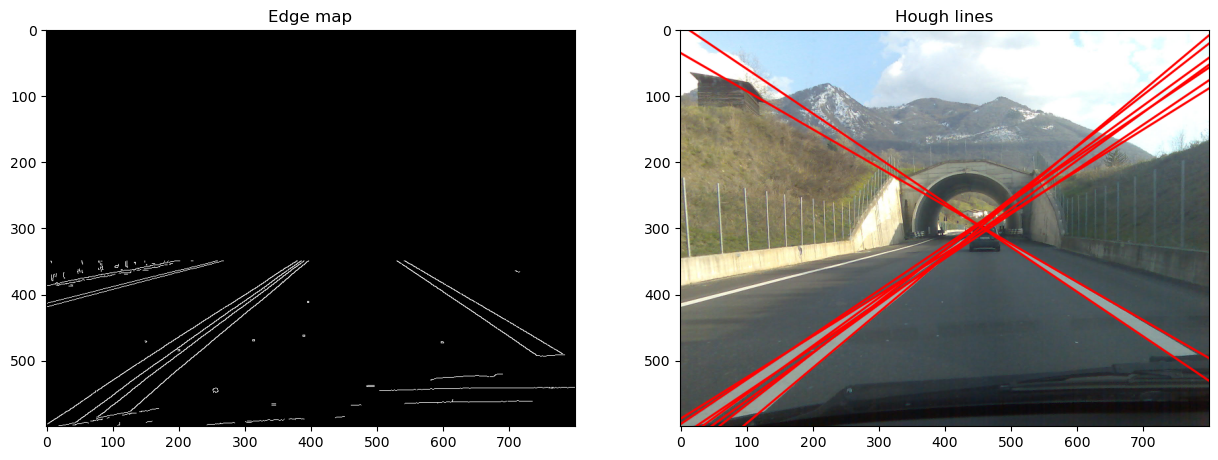

In [33]:
# Let's plot the resulting filtered lines
result = np.copy(img)

for line in filtered_lines:
    rho, theta = line
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
    pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))

    cv2.line(result, pt1, pt2, (255,0,0), 2, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The result is now much better, but still we see some very similar lines. How can we get rid of them?
* Let's apply k-means clustering. It will find the clusters of the 6 we see in the picture lines and use the averages.

In [34]:
# We will apply k-means clustering to refine the detected lines.
# Don't worry, we will learn about the clustering later in the course :-)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0).fit(filtered_lines)
centers = kmeans.cluster_centers_
print("Cluster centers shape:", centers.shape)

Cluster centers shape: (6, 2)


D:\study\programming\conda\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\study\programming\conda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "D:\study\programming\conda\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "D:\study\programming\conda\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

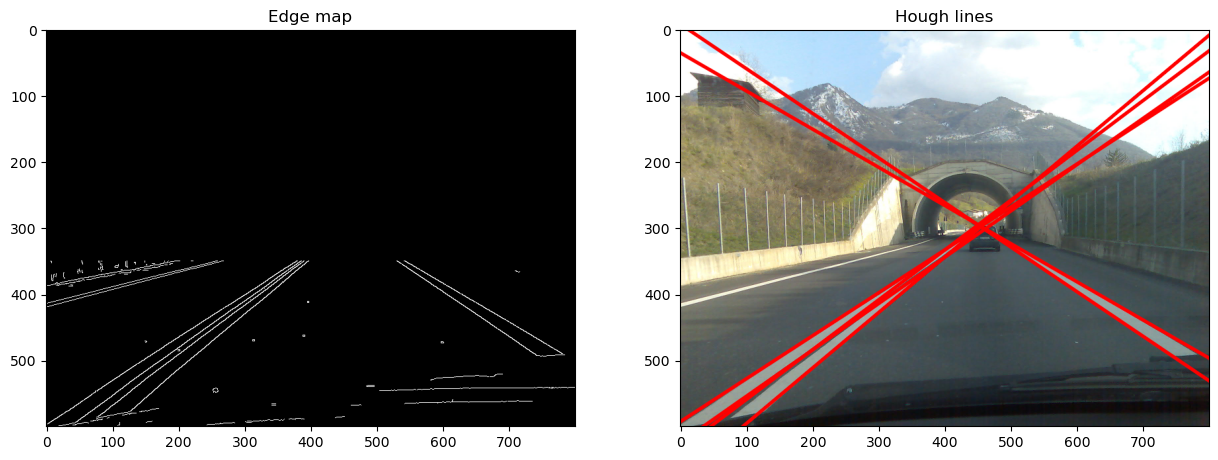

In [35]:
# Again, let's plot the resulting filtered lines
result = np.copy(img)

for rho, theta in centers:
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
    pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))

    cv2.line(result, pt1, pt2, (255,0,0), 3, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

### Questions
* Do you see anything strange in the final result?
* Do you think the Hough transform resolution is important for obtaining a good result? Why?
* Do you think the Hough transform accumulator threshold is important for obtaining a good result? Why?